In [38]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

In [3]:

def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [79]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val

In [13]:
import pandas as pd
import numpy as np
def get_duration_and_size(lab, rettype='df'):
    """Returns either a Pandas DataFrame (default) or dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    # put eventID as key, values are dict: {duration: D, size: [s_0, ..., s_d]}
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev]['duration'] += 1 # continuing
                    dur[ev]['size'].append(np.count_nonzero(tmp==ev))
                else:
                    dur[ev] = dict() # new event
                    dur[ev]['duration'] = 1
                    dur[ev]['size'] = [np.count_nonzero(tmp==ev)]
    if rettype == 'df':
        # convert to dataFrame
        df = pd.DataFrame.from_dict(dur, orient ='index')
        # compute average size and include as a column
        asiz = []
        msiz = []
        for s in df['size']:
            asiz.append(np.mean(s))
            msiz.append(np.max(s))
        df['AvgSiz'] = asiz
        df['MaxSiz'] = msiz
        # get distribution of average size
        return df
    else:
        return dur  # AvgSiz and MaxSiz not included in output dict.

In [173]:
# tup1 = ("IPSL-CM6A-LR", "amip", "r1i1p1f1")
# tup2 = ("IPSL-CM6A-LR", "amip-lwoff", "r1i1p1f1")
# tup1 = ("IPSL-CM6A-LR", "aqua-control", "r1i1p1f1")
# tup2 = ("IPSL-CM6A-LR", "aqua-control-lwoff", "r1i1p1f1")

# tup1 = ("CESM2", "amip", "r1i1p1f1")
# tup2 = ("CESM2", "amip-lwoff", "r1i1p1f1")
# tup1 = ("CESM2", "aqua-control", "r1i1p1f1")
# tup2 = ("CESM2", "aqua-control-lwoff", "r1i1p1f1")

# tup1 = ("CNRM-CM6-1", "amip", "r1i1p1f2")
# tup2 = ("CNRM-CM6-1", "amip-lwoff", "r1i1p1f2")

# tup1 = ("CNRM-CM6-1", "aqua-control", "r1i1p1f2")
# tup2 = ("CNRM-CM6-1", "aqua-control-lwoff", "r1i1p1f2")

tup1 = ("MRI-ESM2-0", "amip", "r1i1p1f1")
tup2 = ("MRI-ESM2-0", "amip-lwoff", "r1i1p1f1")

In [174]:
# load the precipitation data (could be other eventually)
dloc = "/Volumes/Glyph6TB/CMIP6"

pr1 = quick_load_var(dloc, "pr", "day", tup1[0], tup1[1], tup1[2])
pr2 = quick_load_var(dloc, "pr", "day", *tup2)

pr1 *= 86400.
pr2 *= 86400


if "amip" in tup1[1]:
    land1 = quick_load_var(dloc, "sftlf", "fx", *tup1)
    pr1 = pr1.where(land1 <= 0)
if "amip" in tup2[1]:
    land2 = quick_load_var(dloc, "sftlf", "fx", *tup2)
    pr2 = pr2.where(land2 <= 0)



In [175]:
# load the events
ev1 = xr.open_dataset(Path(dloc) / ("pr_events_"+"_".join(tup1)+".nc"))['precip_events']
ev2 = xr.open_dataset(Path(dloc) / ("pr_events_"+"_".join(tup2)+".nc"))['precip_events']

In [176]:
pr1 = pr1.sel(lat=slice(-30,30))
pr2 = pr2.sel(lat=slice(-30,30))

In [177]:
# What if we only consider events that are longer than 1-day
dursiz1 = get_duration_and_size(ev1)
dursiz2 = get_duration_and_size(ev2)

In [178]:
duration_crit = 2  # critical value for duration

In [179]:
evlong1 = dursiz1.where(dursiz1['duration'] > duration_crit).dropna()
# evlong1 only has event labels for longer events.
# now we have to go and get the precipitation within those events
evmask1 = np.in1d(ev1, evlong1.index.values).reshape(ev1.shape)
pr1_long_events = pr1.where(evmask1)
# now what to do with them?

In [180]:
%%time
pr1_all_events = pr1.where(np.in1d(ev1, dursiz1.index.values).reshape(ev1.shape))

CPU times: user 7.66 s, sys: 2.43 s, total: 10.1 s
Wall time: 10.1 s


In [181]:
# do the same calcs for 2nd simulation:
pr2_all_events = pr2.where(np.in1d(ev2, dursiz2.index.values).reshape(ev2.shape))
evlong2 = dursiz2.where(dursiz2['duration'] > duration_crit).dropna()
evmask2 = np.in1d(ev2, evlong2.index.values).reshape(ev2.shape)
pr2_long_events = pr2.where(evmask2)

In [182]:
# non-organized extreme precipitation is just the rest:
evshort1 = dursiz1.where(dursiz1['duration'] <= duration_crit).dropna()
evmask1sh = np.in1d(ev1, evshort1.index.values).reshape(ev1.shape)
pr1_short_events = pr1.where(evmask1sh)

evshort2 = dursiz2.where(dursiz2['duration'] <= duration_crit).dropna()
evmask2sh = np.in1d(ev2, evshort2.index.values).reshape(ev2.shape)
pr2_short_events = pr2.where(evmask2sh)


In [183]:
# look at the distribution
# first of all precipitation:
hpr1, hpredge1 = np.histogram(pr1.values, bins=np.arange(-10., 210., 10), density=True)
hpr1ctr = hpredge1[1:] + np.diff(hpredge1)
hpr1frq = hpr1*np.diff(hpredge1)

# second, all "extreme" precipitation:
hpr1all, hpredge1all = np.histogram(pr1_all_events.values, bins=np.arange(-10., 210., 10), density=True)
hpr1allctr = hpredge1all[1:] + np.diff(hpredge1all)
hpr1allfrq = hpr1all*np.diff(hpredge1all)


# finally, only "extended extreme" 
hpr1long, hpredge1long = np.histogram(pr1_long_events.values, bins=np.arange(-10., 210., 10), density=True)
hpr1longctr = hpredge1long[1:] + np.diff(hpredge1long)
hpr1longfrq = hpr1long*np.diff(hpredge1long)

# PLUS --> non-organized extreme precip (r for random)
h_prr1, h_prr1_edge = np.histogram(pr1_short_events.values, bins=np.arange(-10., 210., 10), density=True)
h_prr1_ctr = h_prr1_edge[1:] + np.diff(h_prr1_edge)
h_prr1_frq = h_prr1 * np.diff(h_prr1_edge)

# 2nds simulation
h_pr2, h_pr2_edge = np.histogram(pr2.values, bins=np.arange(-10., 210., 10), density=True)
h_pr2_ctr = h_pr2_edge[1:] + np.diff(h_pr2_edge)
h_pr2_frq = h_pr2 * np.diff(h_pr2_edge)

h_prx2, h_prx2_edge = np.histogram(pr2_all_events.values, bins=np.arange(-10., 210., 10), density=True)
h_prx2_ctr = h_prx2_edge[1:] + np.diff(h_prx2_edge)
h_prx2_frq = h_prx2 * np.diff(h_prx2_edge)

h_prxl2, h_prxl2_edge = np.histogram(pr2_long_events.values, bins=np.arange(-10., 210., 10), density=True)
h_prxl2_ctr = h_prxl2_edge[1:] + np.diff(h_prxl2_edge)
h_prxl2_frq = h_prxl2 * np.diff(h_prxl2_edge)

h_prr2, h_prr2_edge = np.histogram(pr2_short_events.values, bins=np.arange(-10., 210., 10), density=True)
h_prr2_ctr = h_prr2_edge[1:] + np.diff(h_prr2_edge)
h_prr2_frq = h_prr2 * np.diff(h_prr2_edge)



[]

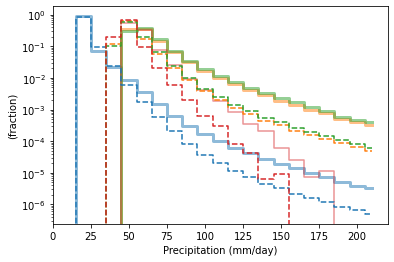

In [186]:
fig, ax = plt.subplots()
ax.step(hpr1ctr, hpr1frq, where='mid', color='C0', linewidth=3, alpha=.5)
ax.step(hpr1allctr, hpr1allfrq, where='mid', color='C1', linewidth=3, alpha=.5)
ax.step(hpr1longctr, hpr1longfrq, where='mid', color='C2', linewidth=3, alpha=.5)
ax.step(h_prr1_ctr, h_prr1_frq, where='mid', color='C3', alpha=.5)

ax.step(h_pr2_ctr, h_pr2_frq, where='mid', color='C0', linestyle="dashed")
ax.step(h_prx2_ctr, h_prx2_frq, where='mid', color='C1',linestyle='dashed')
ax.step(h_prxl2_ctr, h_prxl2_frq, where='mid', color='C2',linestyle='dashed')
ax.step(h_prr2_ctr, h_prr2_frq, where='mid', color='C3', linestyle='dashed')

# ax.step(hpr2ctr, hpr2frq, where='mid')
ax.set_xlabel("Precipitation (mm/day)")
ax.set_ylabel("(fraction)")

ax.semilogy()

In [185]:
# Question: How much of the rain is associated with strong events that last > duration_critical?
pr1_crit = get_tropics_quantiles(pr1, threshold=None, q=0.99)
pr2_crit = get_tropics_quantiles(pr2, q=0.99)

pr1_tot = pr1.sum()
pr1_xsum = pr1.where(pr1 >= pr1_crit).sum()
pr1_xcontrib = pr1_xsum / pr1_tot
pr1_xlcontrib = pr1_long_events.sum()  / pr1_tot

pr2_tot = pr2.sum()
pr2_xsum = pr2.where(pr2 >= pr2_crit).sum()
pr2_xcontrib = pr2_xsum / pr2_tot
pr2_xlcontrib = pr2_long_events.sum() / pr2_tot

print(f"Extreme contribution in control: {pr1_xcontrib.values:.3f}, long-events {pr1_xlcontrib.values:.3f}")
print(f"In LWoff: {pr2_xcontrib.values:.3f}, long-events {pr2_xlcontrib.values:.3f}")

Quantile value: 34.88654716491703
Quantile value: 28.994909439086996
Extreme contribution in control: 0.142, long-events 0.121
In LWoff: 0.101, long-events 0.083
